In [89]:
import os
from typing import *
import operator
from urllib.request import build_opener

from docutils.nodes import system_message
from dotenv import load_dotenv
from numba.np.ufunc.parallel import build_gufunc_kernel
from torch.jit.frontend import build_def
import uuid

load_dotenv()
from IPython.display import Image, display, Markdown
import sqlite3
from pydantic import BaseModel, Field


from langchain_ollama import ChatOllama
from langchain_together import ChatTogether
from langchain_huggingface import HuggingFaceEndpoint,ChatHuggingFace
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage, RemoveMessage, get_buffer_string
# from langchain_community.tools import TavilySearchResults
from langchain_tavily import TavilySearch
from langchain_community.document_loaders import WikipediaLoader
from langchain_core.runnables.config import RunnableConfig
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore
from langgraph.store.base import BaseStore
from langgraph.errors import NodeInterrupt
from langgraph.types import interrupt, Command
from langgraph.constants import Send

In [90]:
# ------------------------------------------------------ #
# GLOBALS
# ------------------------------------------------------ #
TOGETHER_API_KEY = os.getenv("TOGETHER_API_KEY")

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user.
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """"You are collecting information about the user to personalize your responses.

CURRENT USER INFORMATION:
{memory}

INSTRUCTIONS:
1. Review the chat history below carefully
2. Identify new information about the user, such as:
   - Personal details (name, location)
   - Preferences (likes, dislikes)
   - Interests and hobbies
   - Past experiences
   - Goals or future plans
3. Merge any new information with existing memory
4. Format the memory as a clear, bulleted list
5. If new information conflicts with existing memory, keep the most recent version

Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.

Based on the chat history below, please update the user information:"""


In [91]:
# ------------------------------------------------------ #
# MODELS
# ------------------------------------------------------ #
# chat_llm = ChatTogether(model="meta-llama/Llama-3.3-70B-Instruct-Turbo-Free", api_key=TOGETHER_API_KEY)
chat_llm = ChatOllama(model='llama3.2:latest')

In [92]:
# ------------------------------------------------------ #
# STORE
# ------------------------------------------------------ #
in_memory_store = InMemoryStore()

In [93]:
# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memories")

In [94]:

# Save a memory to namespace as key and value
key = str(uuid.uuid4())

# The value needs to be a dictionary
value = {"food_preference" : "I like pizza"}

In [95]:

# Save the memory
in_memory_store.put(namespace_for_memory, key, value)

In [96]:
key

'97da09b4-8fe4-4f51-8ca8-d7369e30519c'

In [97]:
# Search
memories = in_memory_store.search(namespace_for_memory)
print(type(memories))

<class 'list'>


In [98]:

memories[0].dict()

{'namespace': ['1', 'memories'],
 'key': '97da09b4-8fe4-4f51-8ca8-d7369e30519c',
 'value': {'food_preference': 'I like pizza'},
 'created_at': '2025-06-20T15:46:41.388187+00:00',
 'updated_at': '2025-06-20T15:46:41.388188+00:00',
 'score': None}

In [99]:
memory = in_memory_store.get(namespace_for_memory, key)
memory.dict()

{'namespace': ['1', 'memories'],
 'key': '97da09b4-8fe4-4f51-8ca8-d7369e30519c',
 'value': {'food_preference': 'I like pizza'},
 'created_at': '2025-06-20T15:46:41.388187+00:00',
 'updated_at': '2025-06-20T15:46:41.388188+00:00'}

In [100]:
# ------------------------------------------------------ #
# Use semantic search
# ------------------------------------------------------ #
from langchain.embeddings import init_embeddings
from langgraph.store.memory import InMemoryStore

# Create store with semantic search enabled
# embeddings = init_embeddings("openai:text-embedding-3-small")
embeddings = init_embeddings(model="nomic-embed-text", provider='ollama')
store = InMemoryStore(
    index={
        "embed": embeddings,
        "dims": 1536,
    }
)

store.put(("user_123", "memories"), "1", {"text": "I love pizza"})
store.put(("user_123", "memories"), "2", {"text": "I am a plumber"})

items = store.search(
    ("user_123", "memories"), query="I'm hungry", limit=1
)
items

[Item(namespace=['user_123', 'memories'], key='1', value={'text': 'I love pizza'}, created_at='2025-06-20T15:46:41.550431+00:00', updated_at='2025-06-20T15:46:41.550434+00:00', score=0.5926771739597143)]

In [101]:
# ------------------------------------------------------ #
# STATES
# ------------------------------------------------------ #

In [102]:
# ------------------------------------------------------ #
# NODES
# ------------------------------------------------------ #
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    key = "user_memory"
    existing_memory = store.get(namespace, key)

    # Extract the actual memory content if it exists and add a prefix
    if existing_memory:
        # Value is a dictionary with a memory key
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content)

    # Respond using memory as well as the chat history
    response = chat_llm.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Extract the memory
    if existing_memory:
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."

    # Format the memory in the system prompt
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=existing_memory_content)
    new_memory = chat_llm.invoke([SystemMessage(content=system_msg)]+state['messages'])
    print(f'VVV\n{new_memory}\n^^^')

    # Overwrite the existing memory in the store
    key = "user_memory"

    # Write value as a dictionary with a memory key
    store.put(namespace, key, {"memory": new_memory.content})
    return {}

In [103]:
# ------------------------------------------------------ #
# CONDITIONAL EDGES
# ------------------------------------------------------ #

In [104]:
# ------------------------------------------------------ #
# WORKFLOWS
# ------------------------------------------------------ #
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

In [105]:
# ------------------------------------------------------ #
# MEMORIES
# ------------------------------------------------------ #
# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

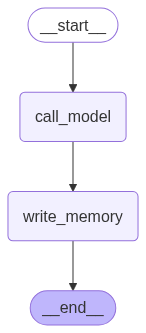

In [106]:
# ------------------------------------------------------ #
# COMPILE
# ------------------------------------------------------ #
# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [107]:
# ------------------------------------------------------ #
# INVOCATION
# ------------------------------------------------------ #
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input
input_messages = [HumanMessage(content="Hi, my name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hello Lance! It's nice to meet you. I don't have any information about you yet, but I'm happy to start a conversation and learn more about you. How's your day going so far?
VVV
content='' additional_kwargs={} response_metadata={'model': 'llama3.2:latest', 'created_at': '2025-06-20T15:46:43.825224Z', 'done': True, 'done_reason': 'stop', 'total_duration': 544057042, 'load_duration': 10258833, 'prompt_eval_count': 226, 'prompt_eval_duration': 532466833, 'eval_count': 1, 'eval_duration': 392708, 'model_name': 'llama3.2:latest'} id='run--1f17575a-78a9-4be5-a472-af86a4496080-0' usage_metadata={'input_tokens': 226, 'output_tokens': 1, 'total_tokens': 227}
^^^


In [108]:
# User input
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

San Francisco is a great city for biking! There are plenty of scenic routes and bike paths that wind through the city. What do you enjoy most about biking in SF - is it the views of the Golden Gate Bridge, the hills, or something else? Have you explored any of the more popular bike spots like Fisherman's Wharf or Golden Gate Park?
VVV
content='' additional_kwargs={} response_metadata={'model': 'llama3.2:latest', 'created_at': '2025-06-20T15:46:46.868365Z', 'done': True, 'done_reason': 'stop', 'total_duration': 763152250, 'load_duration': 10243625, 'prompt_eval_count': 310, 'prompt_eval_duration': 751076500, 'eval_count': 1, 'eval_duration': 401541, 'model_name': 'llama3.2:latest'} id='run--6e3bf236-1d7d-418a-8d0d-412772562db7-0' usage_metadata={'input_tokens': 310, 'output_tokens': 1, 'tot

In [109]:
thread = {"configurable": {"thread_id": "1"}}
state = graph.get_state(thread).values
for m in state["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hello Lance! It's nice to meet you. I don't have any information about you yet, but I'm happy to start a conversation and learn more about you. How's your day going so far?
================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

San Francisco is a great city for biking! There are plenty of scenic routes and bike paths that wind through the city. What do you enjoy most about biking in SF - is it the views of the Golden Gate Bridge, the hills, or something else? Have you explored any of the more popular bike spots like Fisherman's Wharf or Golden Gate Park?


In [87]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'memory': ''},
 'created_at': '2025-06-20T15:45:06.256620+00:00',
 'updated_at': '2025-06-20T15:45:06.256624+00:00'}